# Experimental Design and A/B Testing: A Comprehensive Tutorial

## INTRODUCTION

### What is A/B Testing?

A/B testing (also known as split testing) is a statistical method used to compare two or more versions of a variable to determine which performs better. It's the gold standard for making data-driven decisions in business, science, and product development.

**Real-world applications:**
- **Product Development**: Evaluating new features, user interfaces, or algorithms
- **Healthcare**: Clinical trials to test treatment effectiveness

### WHY THIS TUTORIAL?

This is a guide to:
1. **Design experiments** properly before collecting data
2. **Calculate sample sizes** to ensure your tests have adequate statistical power
3. **Check assumptions** that underlie statistical tests
4. **Perform hypothesis tests** correctly and interpret results
5. **Visualize findings** effectively to communicate insights

---

## ABOUT THE DATASET

We'll use the **Wine Quality Dataset** (red wine variant) from the UCI Machine Learning Repository. This dataset contains physicochemical properties and quality ratings for 1,599 red wines from Portugal.

### Why Wine Data for A/B Testing?

This dataset is ideal for learning A/B testing because:

1. **Multiple variables to test**: We can simulate different "interventions" (alcohol content, pH levels, sulphates) as if we were winemakers testing different production methods

2. **Clear outcome metric**: Wine quality (scored 0-10 by experts) serves as our dependent variable - analogous to conversion rate, revenue, or user satisfaction in business contexts

3. **Realistic distributions**: The data exhibits real-world characteristics like non-normal distributions and unequal variances, forcing us to handle practical complications

4. **Interpretable results**: Everyone understands wine quality, making it easier to grasp statistical concepts without domain expertise

### Dataset Features

| Feature | Description | Type |
|---------|-------------|------|
| **fixed acidity** | Tartaric acid content (g/dm³) | Physicochemical |
| **volatile acidity** | Acetic acid content (g/dm³) | Physicochemical |
| **citric acid** | Citric acid content (g/dm³) | Physicochemical |
| **residual sugar** | Sugar remaining after fermentation (g/dm³) | Physicochemical |
| **chlorides** | Sodium chloride content (g/dm³) | Physicochemical |
| **free sulfur dioxide** | Free SO₂ (mg/dm³) | Physicochemical |
| **total sulfur dioxide** | Total SO₂ (mg/dm³) | Physicochemical |
| **density** | Wine density (g/cm³) | Physicochemical |
| **pH** | Acidity level (0-14 scale) | Physicochemical |
| **sulphates** | Potassium sulphate content (g/dm³) | Physicochemical |
| **alcohol** | Alcohol percentage (% vol) | Physicochemical |
| **quality** | Quality score (0-10) | **Outcome Variable** |

---

## OBJECTIVES

* Formulate testable hypotheses for business questions
* Conduct **power analysis** to determine required sample sizes
* Create appropriate **treatment groups** for experiments
* Check **statistical assumptions** (normality, equal variance)
* Perform **t-tests, ANOVA**, and non-parametric alternatives
* Calculate and interpret **effect sizes** (Cohen's d)
* Understand the difference between **statistical** and **practical** significance
* Apply **Bayesian methods** for probabilistic interpretation
* Create publication-quality **visualizations** of results

---

## THE THREE EXPERIMENTS

We'll simulate three realistic winemaking scenarios:

### Experiment 1: Alcohol Content Intervention
**Business-related question**: "Should we increase alcohol content to improve wine quality?"

**Hypothesis**: Wines with higher alcohol content (≥ median) receive higher quality ratings than wines with lower alcohol content.

**Real-world analogy**: Testing whether a premium product tier (higher price/features) leads to better customer satisfaction.

---

### Experiment 2: pH Level Optimization
**Business-related question**: "Is there an optimal pH range that produces the best wines?"

**Hypothesis**: Wines with pH in the 'optimal' range (3.2-3.4) will have higher quality ratings compared to wines with low (<3.2) or high (>3.4) pH.

**Real-world analogy**: Testing whether there's an optimal price point, ad frequency, or content length that maximizes engagement.

---

### Experiment 3: Sulphates Dosage
**Business-related question**: "What's the ideal sulphate level for quality wine production?"

**Hypothesis**: Moderate sulphate levels produce better wines than very low or very high levels (testing for a non-linear relationship).

**Real-world analogy**: Testing whether moderate push notification frequency works better than very few or very many notifications.

---

## IMPORTANT TO NOTE

### This is observational data, not a true experiment

In a **true A/B test**, we would:
1. Randomly assign wines to treatment groups BEFORE production
2. Control all other variables
3. Measure outcomes after the intervention

This dataset is observational, and we're analyzing wines that already exist. This means:
- It is great for learning statistical techniques
- It is a safe way to practice before running real experiments
- You cannot establish causation (only association)
- You may have confounding variables

When you run actual A/B tests in your work, you'll have true randomization and can make causal claims. The statistical methods remain the same!

---

## PREREQUISITES

Required knowledge:
- Basic Python programming
- Descriptive statistics (mean, median, standard deviation)
- Basic probability concepts
- Familiarity with hypothesis testing (helpful but not required)

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. DATA PREPARATION: 
### Load the Wine Quality dataset (red wine variant)

In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, delimiter=';')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"Quality scores distribution:\n{df['quality'].value_counts().sort_index()}")

Dataset shape: (1599, 12)
Columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
Quality scores distribution:
quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64


## 2. EXPERIMENTAL DESIGN

### Create treatment groups for different experiments:

In [7]:
np.random.seed(42)

### Experiment 1: Alcohol content intervention
Hypothesis: Higher alcohol content improves wine quality

In [9]:
# Experiment 1: 
df['alcohol_group'] = np.where(df['alcohol'] >= df['alcohol'].median(), 
                                'High', 'Low')

### Experiment 2: pH level intervention  
Hypothesis: Optimal pH range (3.2-3.4) produces better quality

In [11]:
# Experiment 2: 
df['ph_group'] = pd.cut(df['pH'], 
                        bins=[df['pH'].min(), 3.2, 3.4, df['pH'].max()],
                        labels=['Low', 'Optimal', 'High'])

### Experiment 3: Sulphates intervention
Hypothesis: Moderate sulphate levels are best

In [13]:
# Experiment 3: 
df['sulphate_group'] = pd.qcut(df['sulphates'], q=3, 
                               labels=['Low', 'Medium', 'High'])

### Print Alcohol and pH groups:

In [15]:
print(f"Alcohol groups: {df['alcohol_group'].value_counts().to_dict()}")
print(f"pH groups: {df['ph_group'].value_counts().to_dict()}")

Alcohol groups: {'High': 803, 'Low': 796}
pH groups: {'Optimal': 824, 'Low': 387, 'High': 387}


## 3. POWER ANALYSIS

### Why Power Analysis Matters?

Imagine launching an A/B test without enough data. You might:
- **Miss real effects** (Type II error) because your sample is too small
- **Waste resources** collecting more data than needed
- **Make wrong decisions** based on inconclusive results

Power analysis answers: "How many samples do I need to reliably detect an effect of size X?"

### Function to calculate required sample size:

In [18]:
def calculate_sample_size(effect_size, power=0.8, alpha=0.05):
    """
    Calculate required sample size per group for t-test
    
    Parameters:
    -----------
    effect_size : float
        Cohen's d effect size
    power : float
        Desired statistical power (default 0.8)
    alpha : float
        Significance level (default 0.05)
    
    Returns:
    --------
    sample_size : int
        Required sample size per group
    """
    analysis = TTestIndPower()
    sample_size = analysis.solve_power(
        effect_size=effect_size,
        power=power,
        alpha=alpha,
        ratio=1.0
    )
    return int(np.ceil(sample_size))

### Calculate for different effect sizes:

In [20]:
print("Required sample sizes per group:")
for effect_size in [0.2, 0.5, 0.8]:
    n = calculate_sample_size(effect_size)
    print(f"  Effect size {effect_size}: {n} samples per group")

Required sample sizes per group:
  Effect size 0.2: 394 samples per group
  Effect size 0.5: 64 samples per group
  Effect size 0.8: 26 samples per group


### Create power analysis visualization
* Plot 1: Sample size vs effect size (with annotations for common effect sizes)
* Plot 2: Power vs sample size for fixed effect size

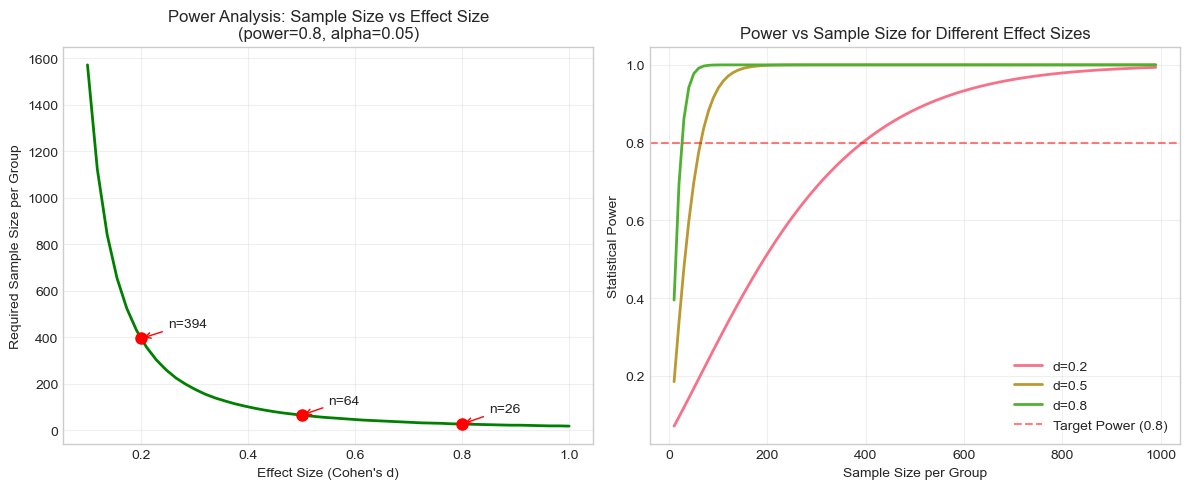

In [22]:
# Create power analysis visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Sample size vs effect size
ax1 = axes[0]
effect_sizes = np.linspace(0.1, 1.0, 50)
sample_sizes = [calculate_sample_size(d) for d in effect_sizes]
ax1.plot(effect_sizes, sample_sizes, 'g-', linewidth=2)
ax1.set_xlabel("Effect Size (Cohen's d)")
ax1.set_ylabel('Required Sample Size per Group')
ax1.set_title('Power Analysis: Sample Size vs Effect Size\n(power=0.8, alpha=0.05)')
ax1.grid(True, alpha=0.3)

# Add annotations for common effect sizes
for es in [0.2, 0.5, 0.8]:
    n = calculate_sample_size(es)
    ax1.plot(es, n, 'ro', markersize=8)
    ax1.annotate(f'n={n}', xy=(es, n), xytext=(es+0.05, n+50),
                 arrowprops=dict(arrowstyle='->', color='red'))

# Plot 2: Power vs sample size for fixed effect size
ax2 = axes[1]
analysis = TTestIndPower()
sample_sizes = np.arange(10, 1000, 10)
for effect_size in [0.2, 0.5, 0.8]:
    power = analysis.power(effect_size=effect_size, 
                          nobs1=sample_sizes, 
                          alpha=0.05,
                          ratio=1.0)
    ax2.plot(sample_sizes, power, label=f'd={effect_size}', linewidth=2)

ax2.axhline(y=0.8, color='r', linestyle='--', alpha=0.5, label='Target Power (0.8)')
ax2.set_xlabel('Sample Size per Group')
ax2.set_ylabel('Statistical Power')
ax2.set_title('Power vs Sample Size for Different Effect Sizes')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('power_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. ASSUMPTION CHECKING

### Why Check Assumptions?

Statistical tests make assumptions about your data. Violating these assumptions can lead to:
- Incorrect p-values (claiming significance when there is none)
- Reduced test power (missing real effects)
- Invalid confidence intervews**: Many tests are "robust" to violations with large sap
roceed.

### Check normality for each group: Normality tests (Shapiro-Wilk)


In [24]:
groups = df['alcohol_group'].unique()
for group in groups:
    data = df[df['alcohol_group'] == group]['quality'].sample(min(5000, len(df[df['alcohol_group'] == group])), 
                                                              random_state=42)
    stat, p_value = stats.shapiro(data)
    print(f"  {group} alcohol group: W={stat:.4f}, p={p_value:.4f}")

  Low alcohol group: W=0.7564, p=0.0000
  High alcohol group: W=0.8744, p=0.0000


### Check equal variance: Levene's test

In [26]:
high_alc = df[df['alcohol_group'] == 'High']['quality']
low_alc = df[df['alcohol_group'] == 'Low']['quality']
stat, p_value = stats.levene(high_alc, low_alc)
print(f"  Levene's test: F={stat:.4f}, p={p_value:.4f}")

  Levene's test: F=25.9085, p=0.0000


### QQ plots for normality check

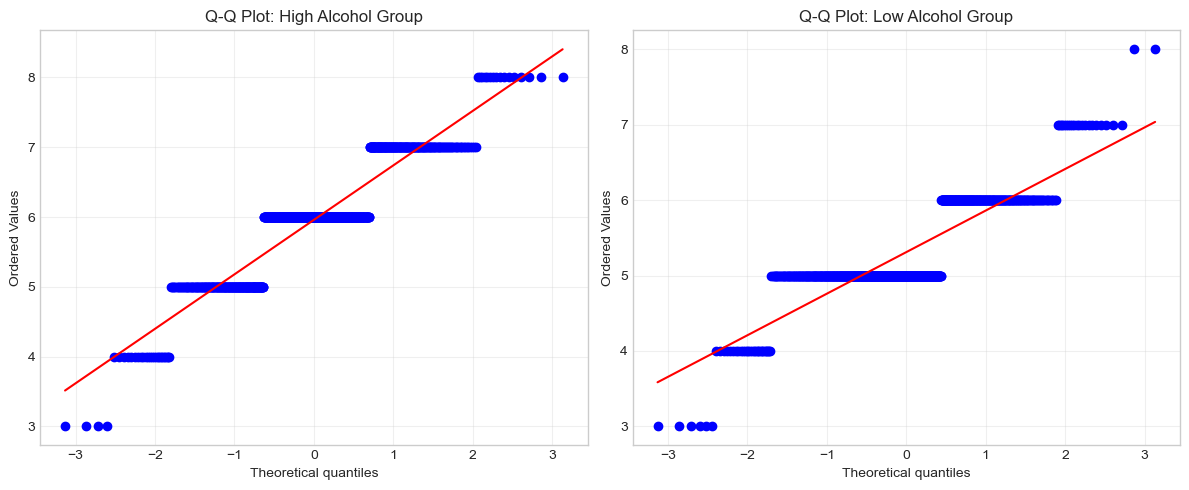

In [28]:
# Create QQ plots for normality check
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# QQ plot for high alcohol group
ax1 = axes[0]
stats.probplot(high_alc, dist="norm", plot=ax1)
ax1.set_title('Q-Q Plot: High Alcohol Group')
ax1.grid(True, alpha=0.3)

# QQ plot for low alcohol group
ax2 = axes[1]
stats.probplot(low_alc, dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot: Low Alcohol Group')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('normality_checks.png', dpi=300, bbox_inches='tight')
plt.show()


## 5. Statistical vs Practical Significance


A result can be:
- **Statistically significant** (p < 0.05) but practically meaningless
- **Practically important** but not statistically significant (underpowered study)

**Example**: Increasing wine quality by 0.01 points might be statistically significant 
with 100,000 samples, but does anyone care about 0.01 poatter?"

### Prepare groups:

In [30]:
control = df[df['alcohol_group'] == 'Low']['quality']
treatment = df[df['alcohol_group'] == 'High']['quality']

print(f"Control group (Low alcohol): n={len(control)}, mean={control.mean():.3f}")
print(f"Treatment group (High alcohol): n={len(treatment)}, mean={treatment.mean():.3f}")

Control group (Low alcohol): n=796, mean=5.310
Treatment group (High alcohol): n=803, mean=5.959


### Perform Welch's t-test (doesn't assume equal variances):
Welch's t-test answers the question: "Are the means of two groups significantly different from each other?"

Specifically, it tests:

-> H0 (Null Hypothesis): mu1 = mu2 (the two population means are equal)

-> H1 (Alternative Hypothesis): mu1 != mu2 (the two population means are different)

In [32]:
t_stat, p_value = stats.ttest_ind(control, treatment, equal_var=False)
print(f"\nWelch's t-test results:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Significant at alpha=0.05: {p_value < 0.05}")


Welch's t-test results:
  t-statistic: -17.5499
  p-value: 0.0000
  Significant at alpha=0.05: True


Which tells us:

- t-statistic = -17.55 => This is how many standard errors the means are apart. The negative sign just means Group 1 (Low alcohol) has a lower mean than Group 2 (High alcohol). The magnitude (17.55) is HUGE - this is a very strong effect.
- p-value ≈ 0.0000 => The probability of seeing this difference (or larger) if the null hypothesis were true is essentially zero. This is extremely strong evidence against H0.
- Conclusion: High alcohol wines have significantly higher quality ratings than low alcohol wines (mean difference = 0.649 points).

Interpretation:
- High alcohol wines have statistically significantly higher quality ratings than low alcohol wines (Welch's t = -17.55, p < 0.001)
- The mean quality difference is 0.649 points (5.959 vs 5.310), which is statistically significant
- We can reject the null hypothesis that alcohol content has no effect on wine quality

### Calculate effect size:

Formula = (Mean1 - Mean2) / Pooled Standard Deviation

Cohen's d tells us: "Is this effect large enough to matter?"

In [35]:
pooled_std = np.sqrt(((len(control)-1)*control.std()**2 + 
                      (len(treatment)-1)*treatment.std()**2) / 
                     (len(control) + len(treatment) - 2))
cohens_d = (treatment.mean() - control.mean()) / pooled_std
print(f"  Cohen's d (effect size): {cohens_d:.3f}")

  Cohen's d (effect size): 0.877


They measure **different but related** things:

| Metric | What it measures | Influenced by |
|--------|------------------|---------------|
| **p-value** (from t-test) | Statistical significance<br>"Is the difference real or random?" | Sample size + effect size |
| **Cohen's d** | Practical significance<br>"How big is the difference?" | Only effect size (NOT sample size) |

- Welch's t-test says: "Yes, there is a difference" 
- Cohen's d = 0.877 says: "And it's a big difference that matters in practice"
- Together they give you confidence (statistical) and magnitude (practical) - both essential for making informed decisions.

### Calculate confidence interval for mean difference

In [38]:
# Calculate mean difference
mean_diff = treatment.mean() - control.mean()

# Calculate standard error of the difference
se_diff = np.sqrt(treatment.var()/len(treatment) + control.var()/len(control))

# Calculate 95% CI using normal approximation (large samples)
ci_lower = mean_diff - 1.96 * se_diff
ci_upper = mean_diff + 1.96 * se_diff

print(f"\n95% Confidence Interval for Mean Difference:")
print(f"  Mean difference: {mean_diff:.3f}")
print(f"  Standard error:  {se_diff:.3f}")
print(f"  95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")


95% Confidence Interval for Mean Difference:
  Mean difference: 0.649
  Standard error:  0.037
  95% CI: [0.576, 0.721]


* Mean difference = 0.649 points
    - High-alcohol wines score on average 0.649 points higher than low-alcohol wines
    - On a 0-10 quality scale, this is about a ~6.5% improvement
    - This is the point estimate - your best single guess of the true effect

---  

* Standard error (SE) = 0.037
    - This measures the precision of your estimate
    - Small SE means precise estimate 
    - It tells you how much the mean difference could vary if you repeated the study many times

---

* 95% CI: [0.576, 0.721]
    - You're 95% confident the true population difference falls in this range
    - The interval is relatively narrow (0.145 points wide) => high precision
    - Both bounds are positive => consistent direction of effect
    - Neither bound includes zero => statistically significant
    

### PH LEVELS:

In [41]:
ph_data = df.dropna(subset=['ph_group'])
ph_groups = {}
for group_name in ['Low', 'Optimal', 'High']:
    ph_groups[group_name] = ph_data[ph_data['ph_group'] == group_name]['quality']
    print(f"{group_name} pH: n={len(ph_groups[group_name])}, "
          f"mean={ph_groups[group_name].mean():.3f}")

Low pH: n=387, mean=5.669
Optimal pH: n=824, mean=5.657
High pH: n=387, mean=5.563


## 6. Visualization

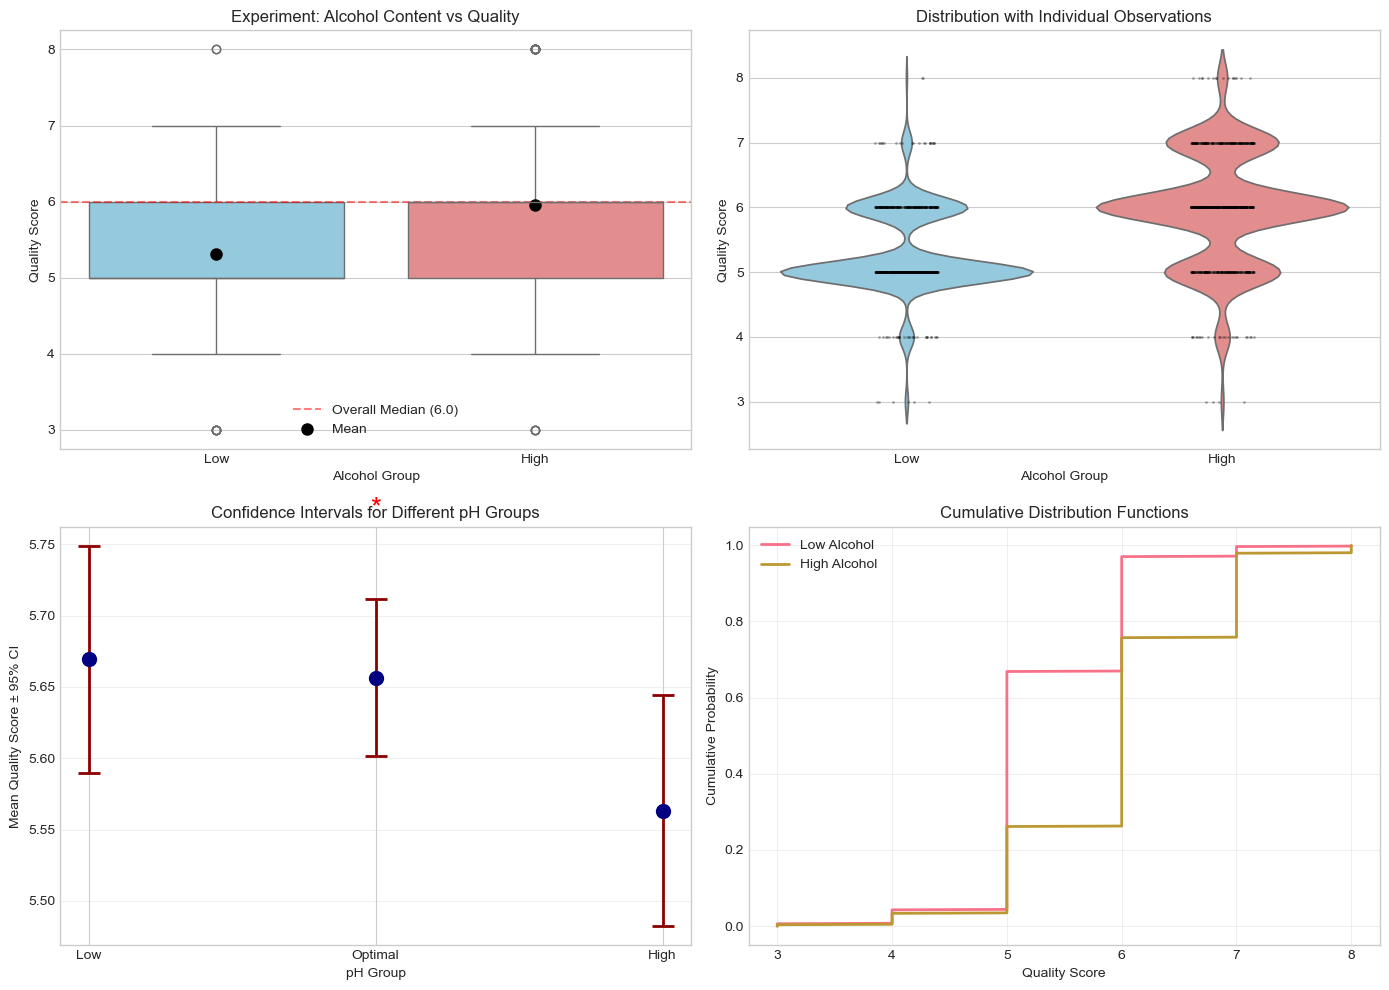

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Box plot of alcohol groups 
ax1 = axes[0, 0]
sns.boxplot(data=df, x='alcohol_group', y='quality', ax=ax1, 
            order=['Low', 'High'], palette=['skyblue', 'lightcoral'])
ax1.set_title('Experiment: Alcohol Content vs Quality')
ax1.set_xlabel('Alcohol Group')
ax1.set_ylabel('Quality Score')

# Add median line 
median_quality = df['quality'].median()
ax1.axhline(y=median_quality, color='r', linestyle='--', alpha=0.5, label=f'Overall Median ({median_quality:.1f})')

# Add mean markers
means = df.groupby('alcohol_group')['quality'].mean()
for i, group in enumerate(['Low', 'High']):
    ax1.plot(i, means[group], 'ko', markersize=8, label=f'Mean' if i == 0 else "")

ax1.legend()

# Plot 2: Violin plot with individual points
ax2 = axes[0, 1]
sns.violinplot(data=df, x='alcohol_group', y='quality', ax=ax2,
               order=['Low', 'High'], palette=['skyblue', 'lightcoral'], inner=None)
sns.stripplot(data=df, x='alcohol_group', y='quality', ax=ax2,
              order=['Low', 'High'], color='black', alpha=0.3, size=2, jitter=True)
ax2.set_title('Distribution with Individual Observations')
ax2.set_xlabel('Alcohol Group')
ax2.set_ylabel('Quality Score')

# Plot 3: Confidence intervals for mean differences
ax3 = axes[1, 0]
groups = list(ph_groups.keys())
means = [ph_groups[g].mean() for g in groups]
cis = [1.96 * ph_groups[g].std() / np.sqrt(len(ph_groups[g])) for g in groups]

colors = ['skyblue', 'lightgreen', 'lightcoral']
ax3.errorbar(groups, means, yerr=cis, fmt='o', capsize=8, capthick=2,
             markersize=10, color='navy', ecolor='darkred', elinewidth=2)
ax3.set_xlabel('pH Group')
ax3.set_ylabel('Mean Quality Score ± 95% CI')
ax3.set_title('Confidence Intervals for Different pH Groups')
ax3.grid(True, alpha=0.3, axis='y')

# Add significance markers
if p_value < 0.05:
    ax3.text(1, max(means) + 0.1, '*', fontsize=20, ha='center', color='red')

# Plot 4: Cumulative distribution functions
ax4 = axes[1, 1]
for group in ['Low', 'High']:
    group_data = df[df['alcohol_group'] == group]['quality']
    sorted_data = np.sort(group_data)
    yvals = np.arange(len(sorted_data)) / float(len(sorted_data))
    ax4.plot(sorted_data, yvals, label=f'{group} Alcohol', linewidth=2)

ax4.set_xlabel('Quality Score')
ax4.set_ylabel('Cumulative Probability')
ax4.set_title('Cumulative Distribution Functions')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ab_testing_results.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. ADDITIONAL ANALYSES
### Non-parametric test (Mann-Whitney U):

In [45]:
print("\nNon-parametric test (Mann-Whitney U):")
u_stat, p_mw = stats.mannwhitneyu(control, treatment, alternative='two-sided')
print(f"  U statistic: {u_stat:.0f}")
print(f"  p-value: {p_mw:.4f}")


Non-parametric test (Mann-Whitney U):
  U statistic: 174635
  p-value: 0.0000


### Bayesian A/B test (simple approximation):

In [47]:
# Using Normal approximation for demonstration
from scipy.stats import norm

# Prior (non-informative)
mu_prior = 0
sigma_prior = 10

# Likelihood
mu_likelihood = treatment.mean() - control.mean()
sigma_likelihood = np.sqrt(treatment.std()**2/len(treatment) + 
                          control.std()**2/len(control))

# Posterior
precision_prior = 1/sigma_prior**2
precision_likelihood = 1/sigma_likelihood**2

posterior_mean = (precision_prior*mu_prior + precision_likelihood*mu_likelihood) / \
                 (precision_prior + precision_likelihood)
posterior_std = np.sqrt(1/(precision_prior + precision_likelihood))

print(f"  Posterior mean difference: {posterior_mean:.3f}")
print(f"  95% credible interval: [{posterior_mean - 1.96*posterior_std:.3f}, "
      f"{posterior_mean + 1.96*posterior_std:.3f}]")

# Probability that treatment is better
prob_better = 1 - norm.cdf(0, posterior_mean, posterior_std)
print(f"  Probability treatment > control: {prob_better:.3%}")

  Posterior mean difference: 0.649
  95% credible interval: [0.576, 0.721]
  Probability treatment > control: 100.000%


### PRACTICAL SIGNIFICANCE: calculate Minimum Detectable Effect (MDE)

In [49]:
def calculate_mde(sample_size_per_group, power=0.8, alpha=0.05):
    """Calculate Minimum Detectable Effect"""
    analysis = TTestIndPower()
    mde = analysis.solve_power(
        nobs1=sample_size_per_group,
        power=power,
        alpha=alpha,
        ratio=1.0
    )
    return mde

In [50]:
current_n = min(len(control), len(treatment))
mde = calculate_mde(current_n)
print(f"\nWith current sample sizes (n={current_n} per group):")
print(f"  Minimum Detectable Effect (Cohen's d): {mde:.3f}")


With current sample sizes (n=796 per group):
  Minimum Detectable Effect (Cohen's d): 0.141


### Convert to actual quality units:

In [52]:
mde_units = mde * pooled_std
print(f"  MDE in quality units: ±{mde_units:.3f} points")

  MDE in quality units: ±0.104 points


### Calculate required sample size for smaller effects:
Calculate the required sample sizes for different effect sizes (0.1, 0.2, 0.3)

In [54]:
for effect_size in [0.1, 0.2, 0.3]:
    n = calculate_sample_size(effect_size)
    print(f"  To detect d={effect_size}: {n:,} samples per group")

  To detect d=0.1: 1,571 samples per group
  To detect d=0.2: 394 samples per group
  To detect d=0.3: 176 samples per group
